imports and data upload
-----------

In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.simplefilter('ignore')
import os
from scipy import stats
import scipy
%matplotlib inline

In [2]:
# upload data
cpath = os.getcwd() #assumes mean_df_females is in the same path as the notebook
mean_df = pd.read_csv(cpath+'/mean_df_female.csv')

# ----------------------------------------------------------------------- 
# ANALYSIS
# -----------------------------------------------------------------------

In [3]:
# plot/colors definitions
data_loc=cpath+'/figs/'
try:
    os.mkdir(data_loc)
except FileExistsError:
    # directory already exists
    pass

plt.style.use("seaborn-paper")
cmap2= ['#EC6D52' , '#5BA6E6']

KLD functions
--------------------------

In [4]:
def KLD_analysis(frequencies):
    '''rows are sessions (or mice/phases), columns are variables (syllables)'''
    cohort_dist=np.zeros((len(frequencies),len(frequencies)),dtype=float)
    x=0
    y=0
    for i in frequencies:
        for j in frequencies:
            i[i==0]=.0000000001
            j[j==0]=.0000000001
            cohort_dist[x,y]=scipy.stats.entropy(pk=np.array(i), qk=np.array(j))
            y=y+1
        y=0
        x=x+1
    return cohort_dist

## KLD calculations

In [5]:
# KLD between individual mice (average syllable use per mouse)
female_mean_df=mean_df.copy()
mm=[]
temp_mean_df= female_mean_df.groupby(by = ['mouse', 'syllable']).mean()['usage'].reset_index()
mean_df_lc = pd.pivot_table(temp_mean_df, values='usage', index=['mouse'], columns=['syllable']).reset_index().fillna(0)
mm=mean_df_lc.drop(['mouse'], axis=1).to_numpy()
KLD_indv = KLD_analysis(mm)
mean_kld_indv = np.mean(KLD_indv,axis=0)

# KLD between phases (within mouse)
temp_mean_df = female_mean_df.groupby(by = ['mouse', 'group', 'syllable']).mean()['usage'].reset_index()
mean_df_lc = pd.pivot_table(temp_mean_df, values='usage', index=['mouse','group'], columns=['syllable']).reset_index().fillna(0)
mean_kld_phase=[]
mice = female_mean_df['mouse'].unique()
for choose in mice:
        curr = mean_df_lc[mean_df_lc['mouse'] == choose]
        curr = curr.drop(['group','mouse'], axis=1).to_numpy()
        KLD_phase = KLD_analysis(curr)
        mean_kld_phase.append(np.mean(KLD_phase))

KLD plots
--------------

In [6]:
# create dataframe and save for female
kld = np.concatenate((np.array(mean_kld_indv),
                      np.array(mean_kld_phase)))
groups = np.concatenate((len(np.array(mean_kld_indv)) * ['indv'],
                         len(np.array(mean_kld_phase)) * ['phase']))
klddata = {'KLD': list(kld), 
           'Groups': list(groups)}
# Create DataFrame
df = pd.DataFrame(klddata)
df = df[(df != 0).all(1)] # remove self distance

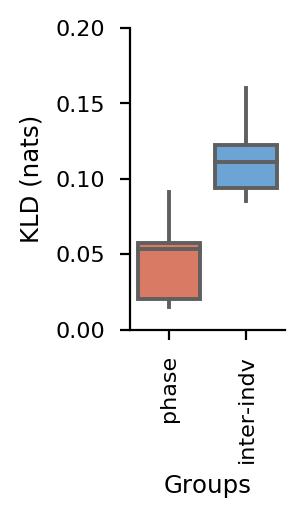

In [7]:
#### plot distributions#####
fig = plt.figure(figsize=(1, 2))
fig.dpi = 200
ax = sns.boxplot(data=df, showfliers=False, showcaps=False,x="Groups",y="KLD",order=['phase','indv'], palette = cmap2)
plt.xticks(ticks=[0, 1], labels=['phase', 'inter-indv'], rotation=90)
ax.set(ylabel='KLD (nats)')
plt.ylim([0,0.2])
sns.despine()
fig.savefig(data_loc +'female_kld_boxplot.pdf', bbox_inches='tight')

statistics
------------

In [8]:
# statistics
print('wilcoxon')
ivsp= stats.wilcoxon(df[df.Groups=='indv'].KLD, df[df.Groups=='phase'].KLD, alternative='two-sided')
print('kld p value:', ivsp.pvalue)
print('kld T statistics:', ivsp.statistic)

wilcoxon
kld p value: 6.103515625e-05
kld T statistics: 1.0


CV instead of KLD
--------------

In [9]:
# CV between mice (average syllable use per mouse)
mm=[]
temp_mean_df= female_mean_df.groupby(by = ['mouse', 'syllable']).mean()['usage'].reset_index()
mean_df_lc = pd.pivot_table(temp_mean_df, values='usage', index=['mouse'], columns=['syllable']).reset_index().fillna(0)
mm=mean_df_lc.drop(['mouse'], axis=1).to_numpy()
sys=np.nanstd(np.array(mm), axis=0)
sym=np.nanmean(np.array(mm), axis=0)
cv_indv=sys/sym # each syllable will have a cv value

# cv between phases (within mouse)
temp_mean_df = female_mean_df.groupby(by = ['mouse', 'group', 'syllable']).mean()['usage'].reset_index()
mean_df_lc = pd.pivot_table(temp_mean_df, values='usage', index=['group', 'mouse'], columns=['syllable']).reset_index().fillna(0)
mice = mean_df_lc['mouse'].unique()
cv_phase=[]
for choose in mice:
        curr = mean_df_lc[mean_df_lc['mouse'] == choose]
        curr = curr.drop(['group','mouse'], axis=1).to_numpy()
        sys=np.nanstd(np.array(curr), axis=0)
        sym=np.nanmean(np.array(curr), axis=0)
        cv_phase.append(sys/sym)
mean_cv_phase = np.mean(cv_phase,axis=0)

## plot cv

In [10]:
# create dataframe and save for female
cv = np.concatenate((np.array(cv_indv),
                      np.array(mean_cv_phase)))
groups = np.concatenate((len(np.array(cv_indv)) * ['indv'],
                         len(np.array(mean_cv_phase)) * ['phase']))
cvdata = {'cv': list(cv), 
           'Groups': list(groups)}
df = pd.DataFrame(cvdata)

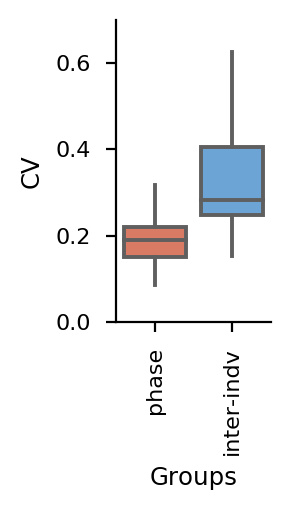

In [11]:
#### plot distributions#####
fig = plt.figure(figsize=(1, 2))
fig.dpi = 200
ax = sns.boxplot(data=df, showfliers=False, showcaps=False,x="Groups",y="cv",order=['phase','indv'],palette = cmap2)
plt.xticks(ticks=[0, 1], labels=['phase', 'inter-indv'], rotation=90)
ax.set(ylabel='CV')
plt.ylim([0,0.7])
sns.despine()
fig.savefig(data_loc +'female_cv_boxplot.pdf', bbox_inches='tight')

In [12]:
print('wilcoxon')
ivsp= stats.wilcoxon(df[df.Groups=='indv'].cv, df[df.Groups=='phase'].cv, alternative='two-sided')
print('kld p value:', ivsp.pvalue)
print('kld T statistics:', ivsp.statistic)

wilcoxon
kld p value: 7.72257004802757e-09
kld T statistics: 32.0
